# 03 — EDA: Category Landscape

**Objective:** Map the competitive landscape of European food categories to identify where private label opportunity exists.

## Analysis-Ready Data
- **699,738 products** with all three: Nutri-Score + category + brand (from 2.57M OFF EU)
- **14,434 supermarket products** with pricing (Mercadona + Albert Heijn)
- **6,200 matched** supermarket-to-OFF products with both nutrition and price

## Key Analyses
1. Category size and Nutri-Score landscape — which categories are dominated by unhealthy products?
2. Brand concentration (HHI) — where are a few brands dominant vs. fragmented markets?
3. Private label penetration — which categories already have strong PL presence?
4. The "nutritional gap" — categories where products are unhealthy AND PL hasn't filled the healthy niche
5. Price analysis — brand vs. PL pricing from supermarket data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure we're in project root for relative paths
os.chdir(os.path.join(os.path.dirname(os.path.abspath('.')), 'notebooks', '..'))

from src.analysis.category_landscape import compute_hhi, compute_pl_penetration
from src.analysis.nutritional_gaps import compute_nutritional_landscape, compute_nutrient_stats
from src.analysis.price_gaps import compute_price_gaps
from src.analysis.opportunity_scorer import normalise_column

# Plotting defaults
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'figure.dpi': 120,
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
})
sns.set_style('whitegrid')

In [2]:
from pathlib import Path

DATA_DIR = Path('data/processed')
RESULTS_DIR = Path('results')
RESULTS_DIR.mkdir(exist_ok=True)

# Load processed data
df_off = pd.read_parquet(DATA_DIR / 'off_eu_clean.parquet')
df_super = pd.read_parquet(DATA_DIR / 'supermarket_all.parquet')
df_matched = pd.read_parquet(DATA_DIR / 'supermarket_off_matched.parquet')

# Filter to analysis-ready products (have nutriscore + category + brand)
mask = (
    df_off['nutriscore_grade'].notna()
    & (df_off['category_l1'] != 'Unknown')
    & df_off['brand_clean'].notna()
)
df = df_off[mask].copy()
print(f'Analysis-ready: {len(df):,} products across {df["category_l1"].nunique()} L1 categories')

# Focus on categories with enough products for meaningful analysis (>= 100)
cat_sizes = df['category_l1'].value_counts()
big_cats = cat_sizes[cat_sizes >= 100].index
df = df[df['category_l1'].isin(big_cats)].copy()
print(f'After size filter (>=100): {len(df):,} products, {len(big_cats)} L1 categories')

Analysis-ready: 699,738 products across 2754 L1 categories
After size filter (>=100): 694,313 products, 45 L1 categories


## 1. Nutri-Score Landscape by Category

The core question: **which food categories are dominated by nutritionally poor products?**

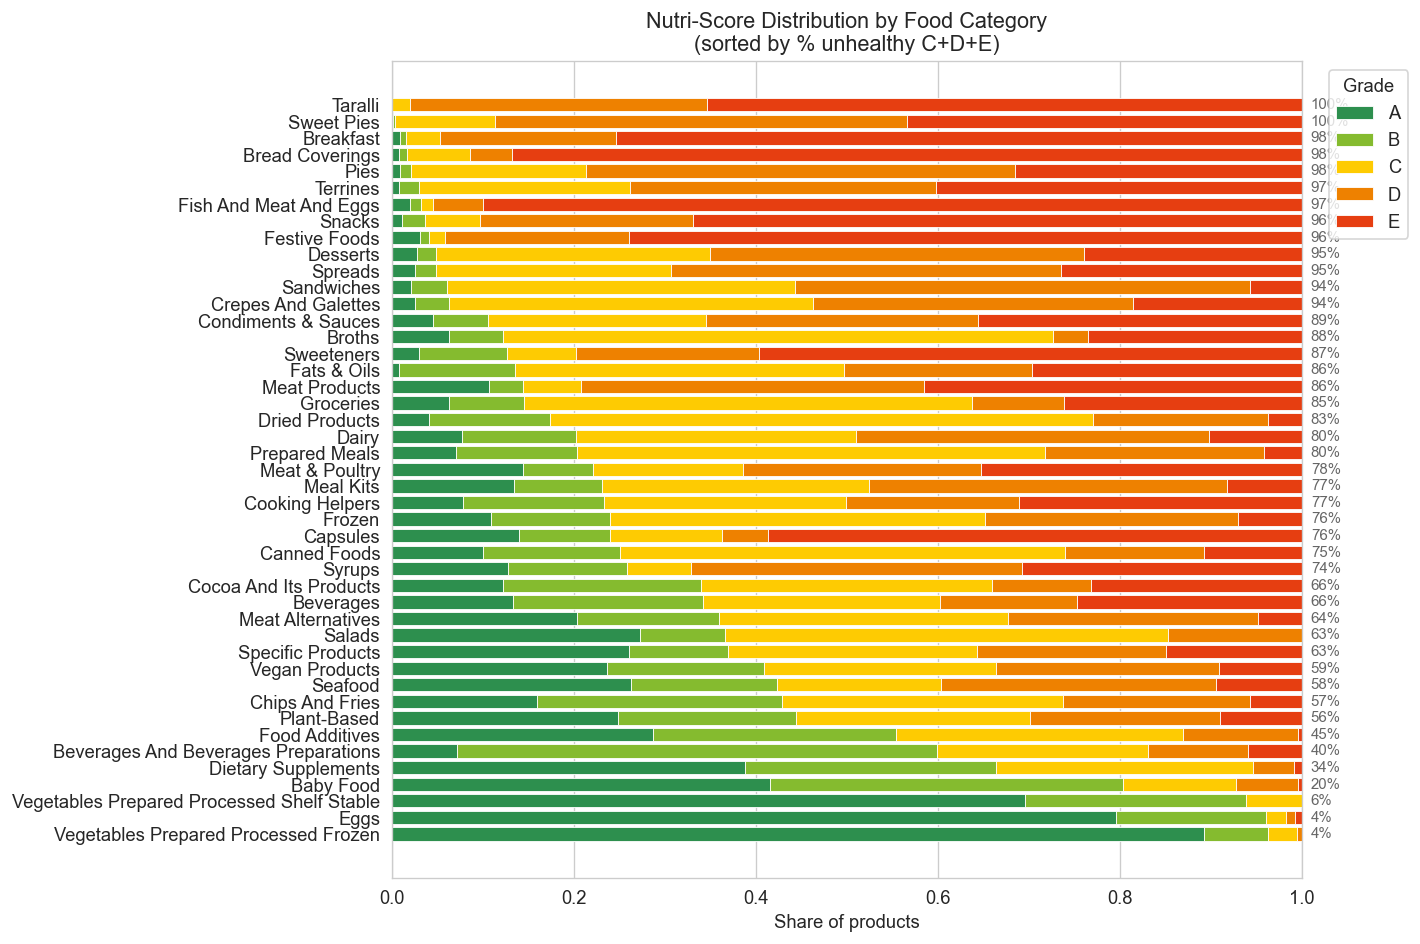


Top 5 categories by % unhealthy (C+D+E):
  Pies: 97.9%
  Bread Coverings: 98.4%
  Breakfast: 98.4%
  Sweet Pies: 99.6%
  Taralli: 100.0%


In [3]:
# Nutri-Score distribution per L1 category (stacked horizontal bar)
landscape = compute_nutritional_landscape(df, 'category_l1')

# Sort by % unhealthy (C+D+E)
landscape = landscape.sort_values('pct_grade_cde', ascending=True)

fig, ax = plt.subplots(figsize=(12, 8))
grade_cols = ['pct_grade_a', 'pct_grade_b', 'pct_grade_c', 'pct_grade_d', 'pct_grade_e']
colors = ['#2d8f4e', '#85bb2f', '#fecb02', '#ee8100', '#e63e11']  # Official Nutri-Score colours
labels = ['A', 'B', 'C', 'D', 'E']

left = np.zeros(len(landscape))
for col, color, label in zip(grade_cols, colors, labels):
    vals = landscape[col].values
    ax.barh(landscape['category_l1'], vals, left=left, color=color, label=label, edgecolor='white', linewidth=0.5)
    left += vals

ax.set_xlabel('Share of products')
ax.set_title('Nutri-Score Distribution by Food Category\n(sorted by % unhealthy C+D+E)')
ax.legend(title='Grade', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_xlim(0, 1)

# Add % CDE annotation on right
for i, (_, row) in enumerate(landscape.iterrows()):
    ax.text(1.01, i, f"{row['pct_grade_cde']:.0%}", va='center', fontsize=9, color='#666')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'nutriscore_by_category.png', bbox_inches='tight', dpi=150)
plt.show()
print('\nTop 5 categories by % unhealthy (C+D+E):')
for _, row in landscape.tail(5).iterrows():
    print(f"  {row['category_l1']}: {row['pct_grade_cde']:.1%}")

## 2. Brand Concentration (HHI)

Categories with **low** HHI (fragmented, many small brands) are easier to enter.
Categories with **high** HHI (concentrated, few dominant brands) may be harder but also more profitable if you can compete.

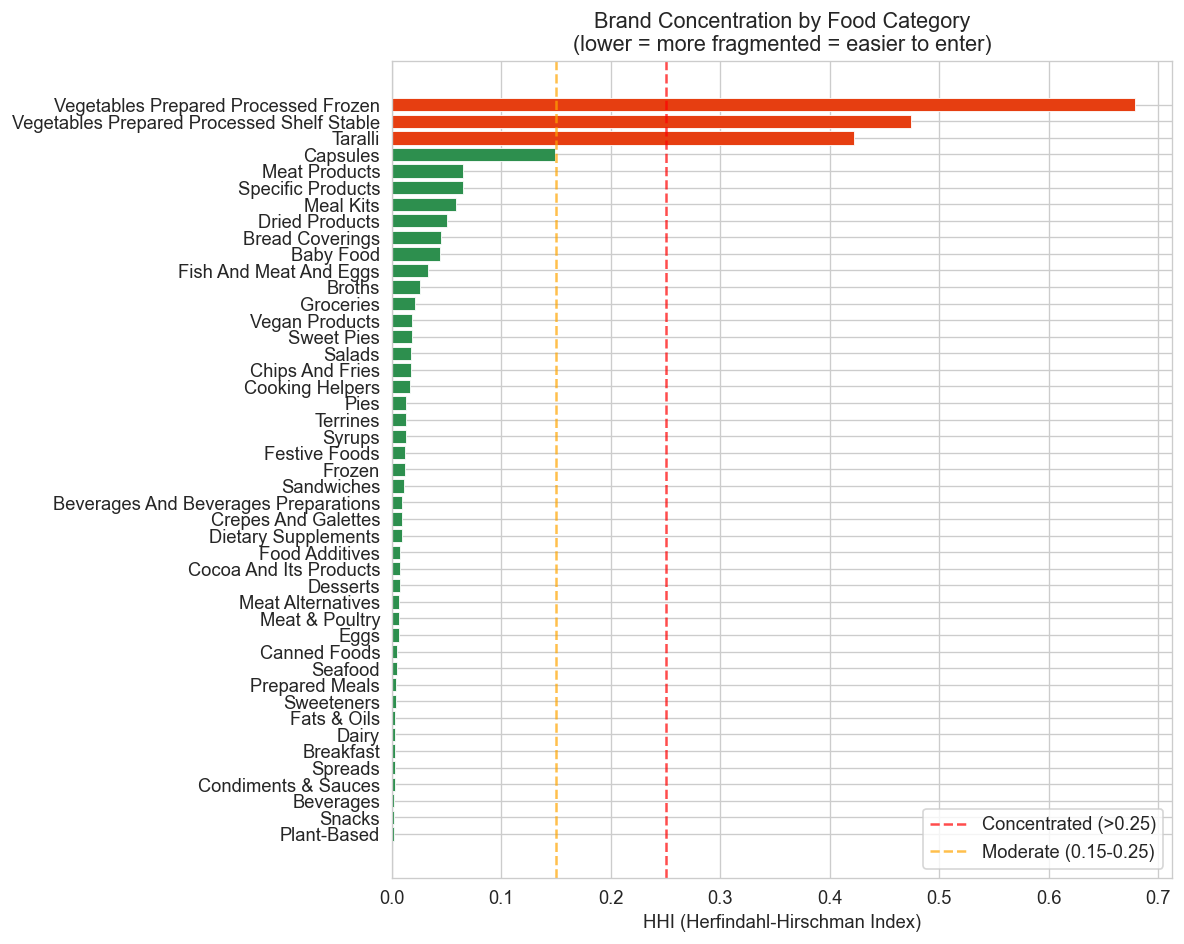

Most concentrated (HHI > 0.15):
  Vegetables Prepared Processed Frozen: HHI=0.679
  Vegetables Prepared Processed Shelf Stable: HHI=0.474
  Taralli: HHI=0.422

Most fragmented (HHI < 0.05):
  Plant-Based: HHI=0.002
  Snacks: HHI=0.002
  Beverages: HHI=0.002
  Condiments & Sauces: HHI=0.003
  Spreads: HHI=0.003
  Breakfast: HHI=0.003
  Dairy: HHI=0.003
  Fats & Oils: HHI=0.003
  Sweeteners: HHI=0.004
  Prepared Meals: HHI=0.004
  Seafood: HHI=0.005
  Canned Foods: HHI=0.005
  Eggs: HHI=0.007
  Meat & Poultry: HHI=0.007
  Meat Alternatives: HHI=0.007
  Desserts: HHI=0.007
  Cocoa And Its Products: HHI=0.008
  Food Additives: HHI=0.008
  Dietary Supplements: HHI=0.009
  Crepes And Galettes: HHI=0.009
  Beverages And Beverages Preparations: HHI=0.010
  Sandwiches: HHI=0.011
  Frozen: HHI=0.012
  Festive Foods: HHI=0.012
  Syrups: HHI=0.013
  Terrines: HHI=0.013
  Pies: HHI=0.013
  Cooking Helpers: HHI=0.017
  Chips And Fries: HHI=0.017
  Salads: HHI=0.018
  Sweet Pies: HHI=0.018
  Vegan Pr

In [4]:
# HHI by L1 category
hhi = compute_hhi(df, 'category_l1', 'brand_clean')
hhi = hhi.sort_values('hhi', ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
colors_hhi = ['#e63e11' if h > 0.25 else '#fecb02' if h > 0.15 else '#2d8f4e' for h in hhi['hhi']]
ax.barh(hhi['category_l1'], hhi['hhi'], color=colors_hhi, edgecolor='white', linewidth=0.5)
ax.axvline(0.25, color='red', linestyle='--', alpha=0.7, label='Concentrated (>0.25)')
ax.axvline(0.15, color='orange', linestyle='--', alpha=0.7, label='Moderate (0.15-0.25)')
ax.set_xlabel('HHI (Herfindahl-Hirschman Index)')
ax.set_title('Brand Concentration by Food Category\n(lower = more fragmented = easier to enter)')
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'hhi_by_category.png', bbox_inches='tight', dpi=150)
plt.show()

print('Most concentrated (HHI > 0.15):')
for _, row in hhi[hhi['hhi'] > 0.15].sort_values('hhi', ascending=False).iterrows():
    print(f"  {row['category_l1']}: HHI={row['hhi']:.3f}")
print('\nMost fragmented (HHI < 0.05):')
for _, row in hhi[hhi['hhi'] < 0.05].sort_values('hhi').iterrows():
    print(f"  {row['category_l1']}: HHI={row['hhi']:.3f}")

## 3. Private Label Penetration

Where do private labels already have a strong presence? Categories with **low** PL penetration represent untapped opportunity.

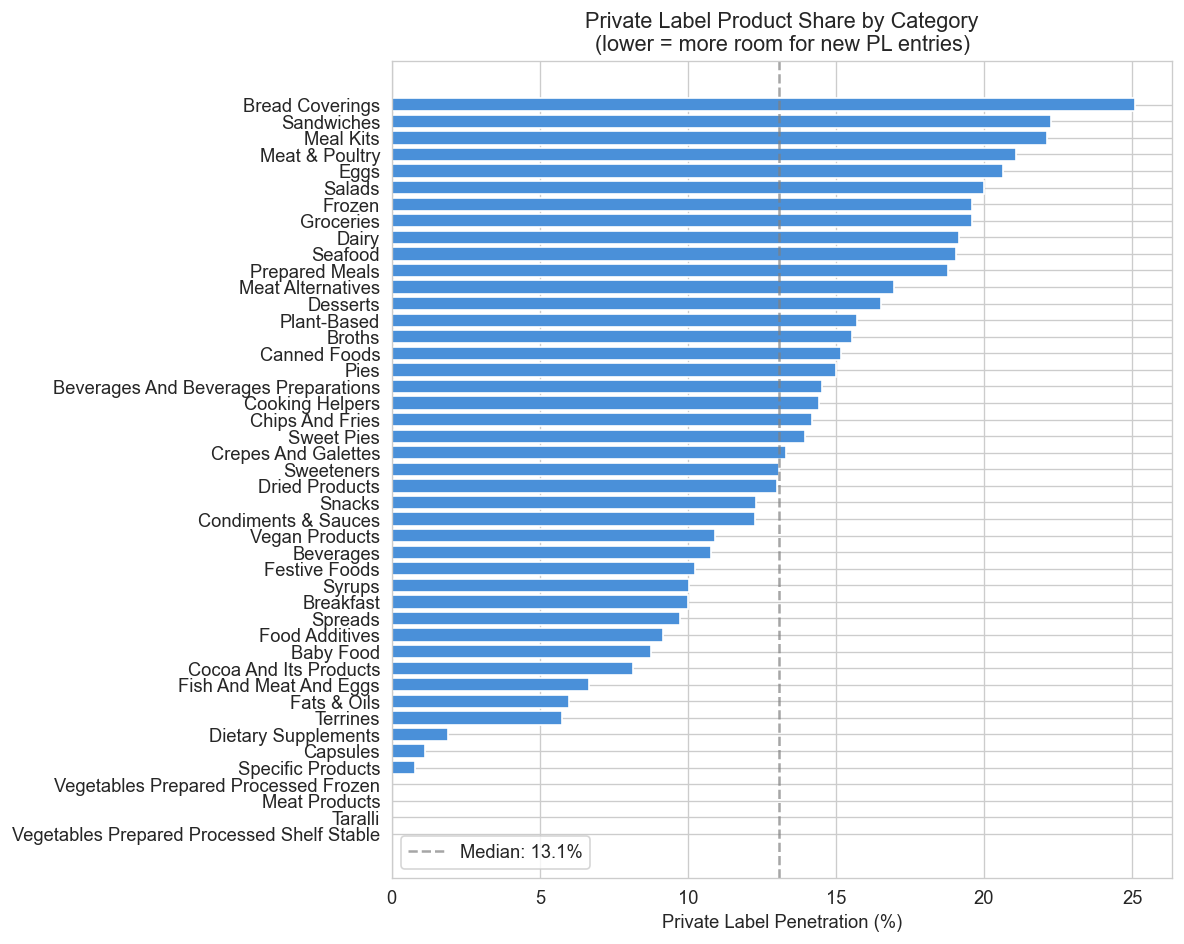

PL penetration among HEALTHY (A+B) products:
  Meal Kits: 45.8% (22/48)
  Sweet Pies: 33.3% (1/3)
  Groceries: 30.4% (21/69)
  Pies: 28.6% (2/7)
  Bread Coverings: 25.0% (1/4)
  Salads: 23.6% (13/55)
  Seafood: 22.7% (2720/12001)
  Sandwiches: 20.6% (42/204)
  Eggs: 20.5% (614/3002)
  Terrines: 18.2% (2/11)


In [5]:
# PL penetration by L1 category
pl_pen = compute_pl_penetration(df, 'category_l1')
pl_pen = pl_pen.sort_values('pl_penetration', ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(pl_pen['category_l1'], pl_pen['pl_penetration'] * 100, color='#4a90d9', edgecolor='white')
ax.set_xlabel('Private Label Penetration (%)')
ax.set_title('Private Label Product Share by Category\n(lower = more room for new PL entries)')
ax.axvline(pl_pen['pl_penetration'].median() * 100, color='gray', linestyle='--', alpha=0.7,
           label=f"Median: {pl_pen['pl_penetration'].median()*100:.1f}%")
ax.legend()
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'pl_penetration_by_category.png', bbox_inches='tight', dpi=150)
plt.show()

# PL penetration specifically among healthy (A+B) products
df_ab = df[df['nutriscore_grade'].isin(['a', 'b'])]
pl_pen_ab = compute_pl_penetration(df_ab, 'category_l1')
pl_pen_ab = pl_pen_ab.rename(columns={'pl_penetration': 'pl_penetration_ab'})

print('PL penetration among HEALTHY (A+B) products:')
for _, row in pl_pen_ab.sort_values('pl_penetration_ab', ascending=False).head(10).iterrows():
    print(f"  {row['category_l1']}: {row['pl_penetration_ab']:.1%} ({row['pl_products']:.0f}/{row['total_products']:.0f})")

## 4. The Nutritional Gap — Core Opportunity Metric

**Nutritional Gap = (% products C/D/E) x (1 - PL penetration among A/B products)**

High gap = most products are unhealthy AND private labels haven't filled the healthy niche yet.
This is the single most important signal for where a health-positioned PL product can succeed.

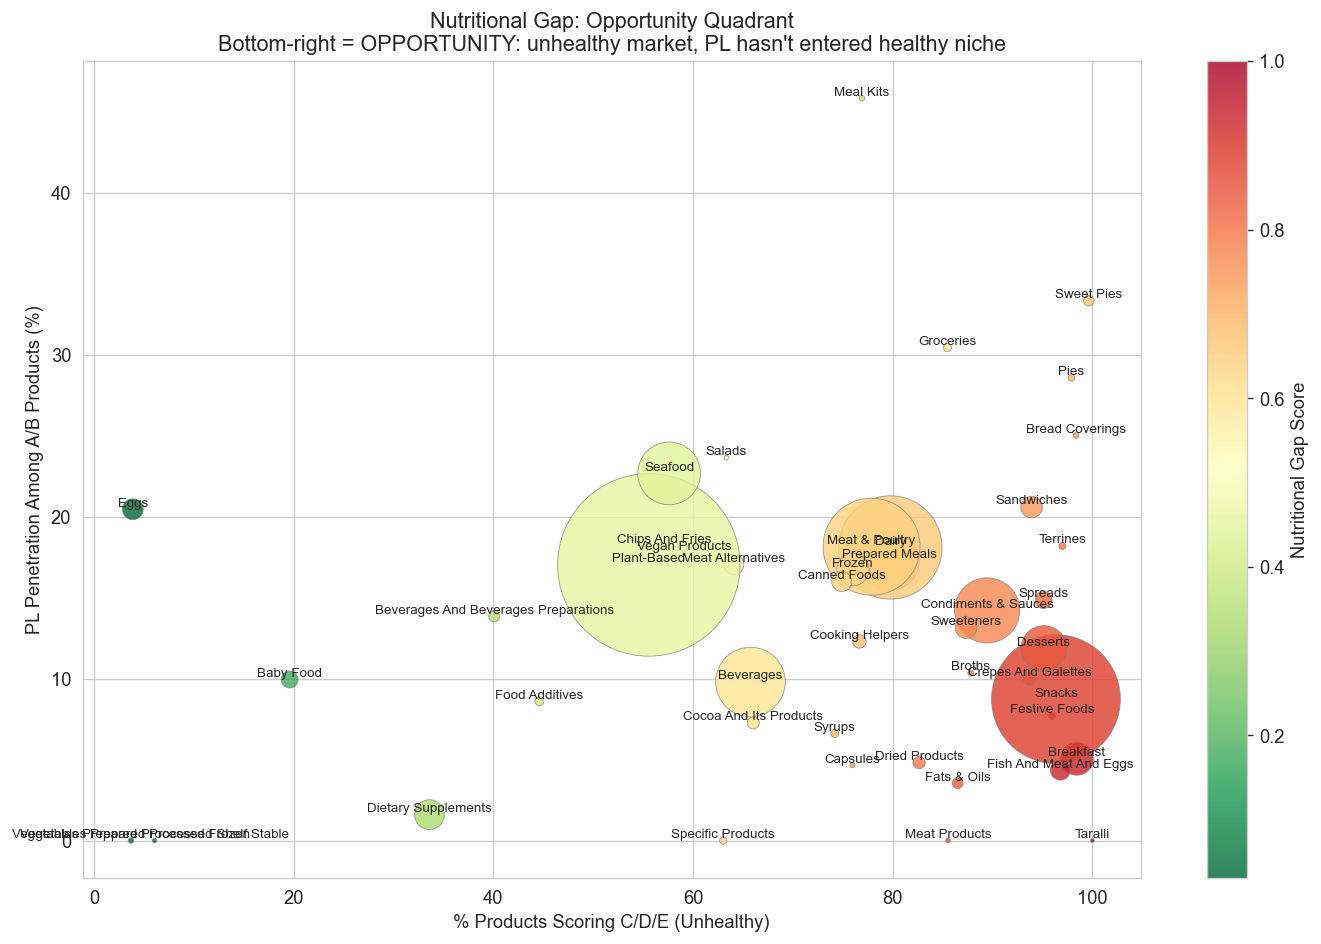


Top 10 Nutritional Gap Opportunities:
  1. Taralli: gap=1.000 (CDE=100.0%, PL@AB=0.0%)
  2. Breakfast: gap=0.935 (CDE=98.4%, PL@AB=5.0%)
  3. Fish And Meat And Eggs: gap=0.926 (CDE=96.8%, PL@AB=4.3%)
  4. Festive Foods: gap=0.886 (CDE=96.0%, PL@AB=7.7%)
  5. Snacks: gap=0.879 (CDE=96.3%, PL@AB=8.7%)
  6. Meat Products: gap=0.855 (CDE=85.5%, PL@AB=0.0%)
  7. Crepes And Galettes: gap=0.843 (CDE=93.7%, PL@AB=10.0%)
  8. Desserts: gap=0.839 (CDE=95.1%, PL@AB=11.9%)
  9. Fats & Oils: gap=0.834 (CDE=86.5%, PL@AB=3.5%)
  10. Spreads: gap=0.810 (CDE=95.1%, PL@AB=14.9%)


In [6]:
# Build the nutritional gap metric
gap_df = landscape[['category_l1', 'pct_grade_cde']].merge(
    pl_pen_ab[['category_l1', 'pl_penetration_ab']], on='category_l1', how='left'
)
gap_df['pl_penetration_ab'] = gap_df['pl_penetration_ab'].fillna(0)
gap_df['nutritional_gap'] = gap_df['pct_grade_cde'] * (1 - gap_df['pl_penetration_ab'])
gap_df = gap_df.sort_values('nutritional_gap', ascending=False)

# Scatter plot: % unhealthy vs PL penetration at A+B
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(
    gap_df['pct_grade_cde'] * 100,
    gap_df['pl_penetration_ab'] * 100,
    s=cat_sizes.reindex(gap_df['category_l1']).values / 20,
    c=gap_df['nutritional_gap'],
    cmap='RdYlGn_r',
    alpha=0.8,
    edgecolors='gray',
    linewidth=0.5,
)

for _, row in gap_df.iterrows():
    ax.annotate(
        row['category_l1'],
        (row['pct_grade_cde'] * 100, row['pl_penetration_ab'] * 100),
        fontsize=8, ha='center', va='bottom',
    )

ax.set_xlabel('% Products Scoring C/D/E (Unhealthy)')
ax.set_ylabel('PL Penetration Among A/B Products (%)')
ax.set_title('Nutritional Gap: Opportunity Quadrant\nBottom-right = OPPORTUNITY: unhealthy market, PL hasn\'t entered healthy niche')
plt.colorbar(scatter, label='Nutritional Gap Score', ax=ax)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'nutritional_gap_quadrant.png', bbox_inches='tight', dpi=150)
plt.show()

print('\nTop 10 Nutritional Gap Opportunities:')
for i, (_, row) in enumerate(gap_df.head(10).iterrows(), 1):
    print(f"  {i}. {row['category_l1']}: gap={row['nutritional_gap']:.3f} "
          f"(CDE={row['pct_grade_cde']:.1%}, PL@AB={row['pl_penetration_ab']:.1%})")

## 5. Price Analysis — Brand vs. Private Label

Using supermarket scrape data to quantify the pricing advantage of private label products.

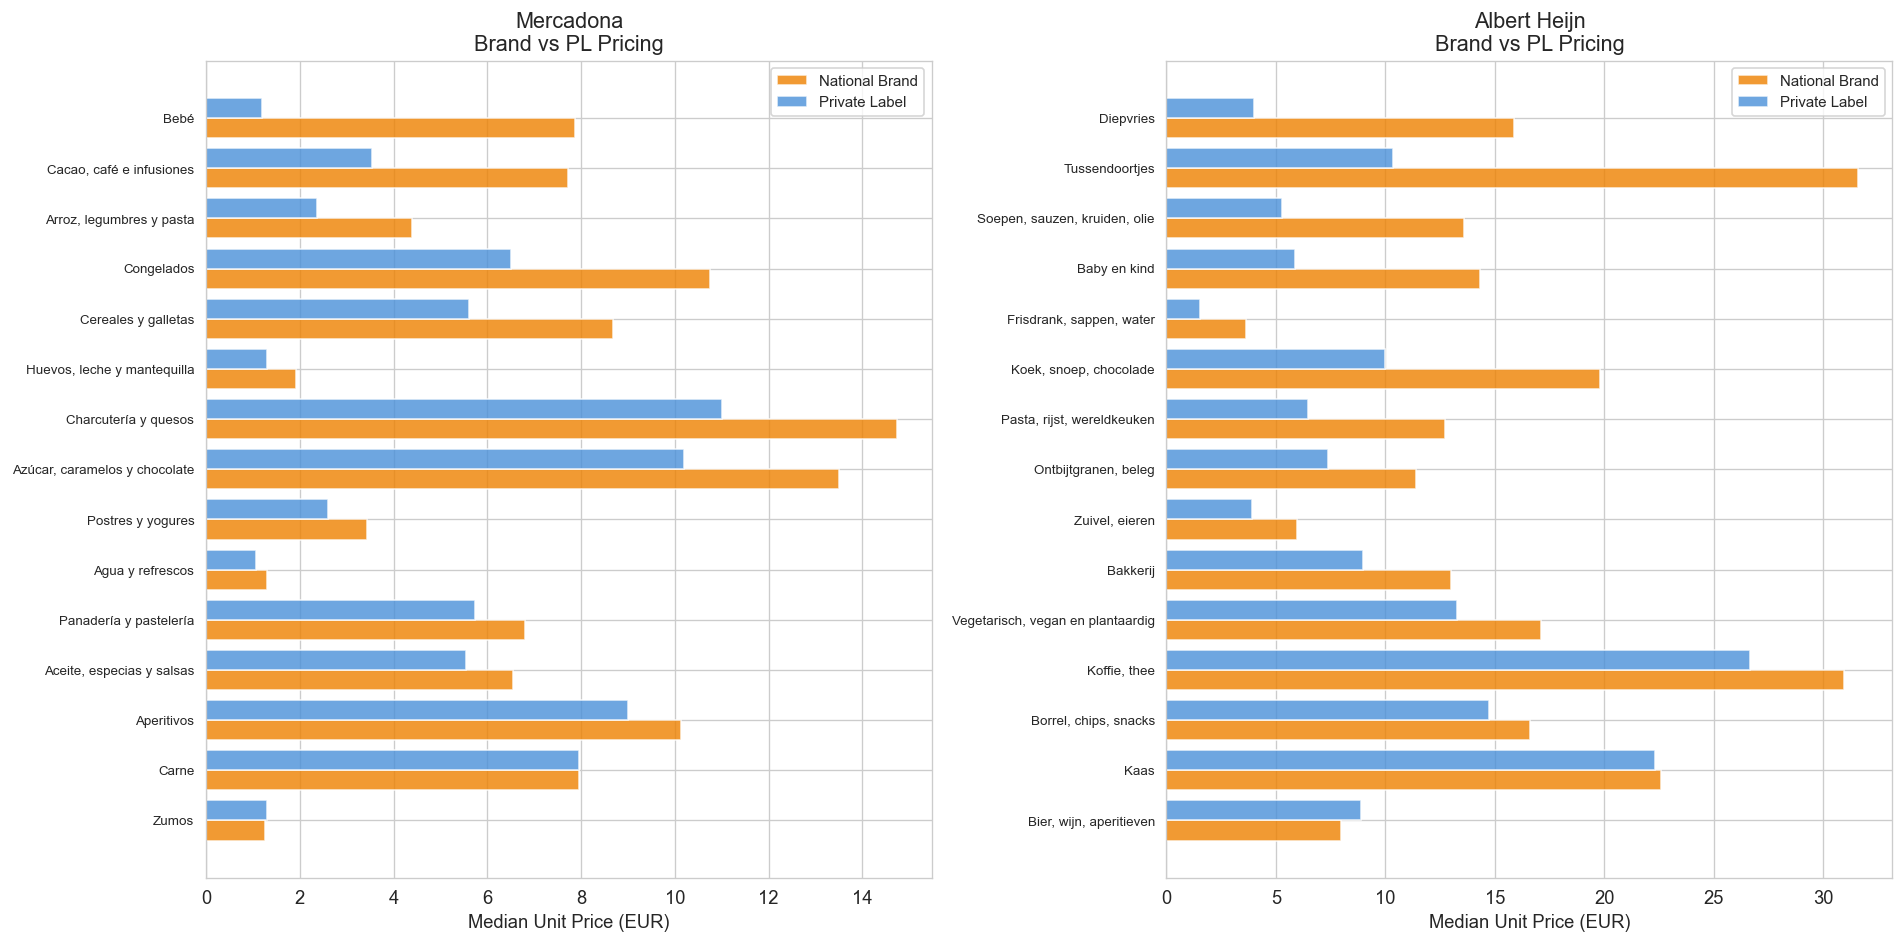


Overall PL discount statistics:
  Median PL discount: 22.4%
  Mean PL discount: 4.6%
  Categories with >30% PL discount: 16


In [7]:
# Price gap analysis from supermarket data
df_super_price = df_super.dropna(subset=['unit_price_eur']).copy()
df_super_price['category_broad'] = df_super_price['category_path'].apply(
    lambda p: p[0] if isinstance(p, (list, np.ndarray)) and len(p) > 0 else 'Unknown'
)
df_super_price = df_super_price[df_super_price['category_broad'] != 'Unknown']

price_gaps = compute_price_gaps(
    df_super_price, 'category_broad', price_col='unit_price_eur'
)

if len(price_gaps) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    for i, retailer in enumerate(['mercadona', 'albert_heijn']):
        ax = axes[i]
        ret_data = price_gaps[price_gaps['retailer'] == retailer].sort_values('pl_discount_pct', ascending=True).tail(15)
        if len(ret_data) == 0:
            continue
        y = range(len(ret_data))
        ax.barh(y, ret_data['branded_median_price'], color='#ee8100', alpha=0.8, label='National Brand', height=0.4)
        ax.barh([yi + 0.4 for yi in y], ret_data['pl_median_price'], color='#4a90d9', alpha=0.8, label='Private Label', height=0.4)
        ax.set_yticks([yi + 0.2 for yi in y])
        ax.set_yticklabels(ret_data['category_broad'], fontsize=8)
        ax.set_xlabel('Median Unit Price (EUR)')
        ax.set_title(f"{retailer.replace('_', ' ').title()}\nBrand vs PL Pricing")
        ax.legend(fontsize=9)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'price_gaps_by_retailer.png', bbox_inches='tight', dpi=150)
    plt.show()
    
    print(f'\nOverall PL discount statistics:')
    print(f"  Median PL discount: {price_gaps['pl_discount_pct'].median():.1f}%")
    print(f"  Mean PL discount: {price_gaps['pl_discount_pct'].mean():.1f}%")
    print(f"  Categories with >30% PL discount: {(price_gaps['pl_discount_pct'] > 30).sum()}")
else:
    print('No price gap data available')

## 6. Combined Category Summary Table

Pull all metrics together into one table per L1 category for the opportunity scoring in notebook 05.

In [8]:
# Build combined category summary
summary = gap_df[['category_l1', 'pct_grade_cde', 'pl_penetration_ab', 'nutritional_gap']].copy()
summary = summary.merge(hhi, on='category_l1', how='left')
summary = summary.merge(
    pl_pen[['category_l1', 'pl_penetration', 'total_products']], on='category_l1', how='left'
)

cat_counts = df['category_l1'].value_counts().reset_index()
cat_counts.columns = ['category_l1', 'n_products']
summary = summary.merge(cat_counts, on='category_l1', how='left')
summary = summary.sort_values('nutritional_gap', ascending=False)

print('CATEGORY LANDSCAPE SUMMARY')
print('=' * 100)
print(f"{'Category':<25} {'N Prods':>8} {'%CDE':>6} {'PL@AB':>6} {'Gap':>6} {'HHI':>6} {'PL%':>6}")
print('-' * 100)
for _, row in summary.iterrows():
    print(f"{row['category_l1']:<25} {row['n_products']:>8,.0f} "
          f"{row['pct_grade_cde']:>5.0%} {row['pl_penetration_ab']:>5.0%} "
          f"{row['nutritional_gap']:>5.3f} {row['hhi']:>5.3f} "
          f"{row['pl_penetration']:>5.0%}")

# Save for downstream notebooks
summary.to_parquet(DATA_DIR / 'category_summary.parquet', index=False)
print(f'\nSaved category summary to {DATA_DIR / "category_summary.parquet"}')

CATEGORY LANDSCAPE SUMMARY
Category                   N Prods   %CDE  PL@AB    Gap    HHI    PL%
----------------------------------------------------------------------------------------------------
Taralli                        101  100%    0% 1.000 0.422    0%
Breakfast                    7,674   98%    5% 0.935 0.003   10%
Fish And Meat And Eggs       2,866   97%    4% 0.926 0.033    7%
Festive Foods                  322   96%    8% 0.886 0.012   10%
Snacks                     119,433   96%    9% 0.879 0.002   12%
Meat Products                  159   86%    0% 0.855 0.065    0%
Crepes And Galettes          1,269   94%   10% 0.843 0.009   13%
Desserts                    15,079   95%   12% 0.839 0.007   17%
Fats & Oils                    837   86%    4% 0.834 0.003    6%
Spreads                      2,063   95%   15% 0.810 0.003   10%
Terrines                       366   97%   18% 0.794 0.013    6%
Broths                         238   88%   10% 0.787 0.026   16%
Dried Products        